In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, SelectKBest, chi2
import statsmodels.api as sm
import numpy as np
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import seaborn as sns

In [2]:
us_counties_df = pd.read_csv(r'us-counties.csv')

In [77]:
dates = ['2020-01-22', '2020-02-22', '2020-03-22', '2020-04-22']
us_counties = us_counties_df[us_counties_df['date'].isin(dates)][['date', 'cases', 'deaths']]
test_data_melt = pd.melt(us_counties, id_vars='date',
                           var_name="source", value_name="value_numbers").groupby(['date', 'source']).sum()

In [81]:
test_data_melt

value_numbers
date       source               
2020-01-22 cases               1
           deaths              0
2020-02-22 cases              30
           deaths              0
2020-03-22 cases           33050
           deaths            435
2020-04-22 cases          833025
           deaths          42489

Text(0,0.5,'cumulative count')

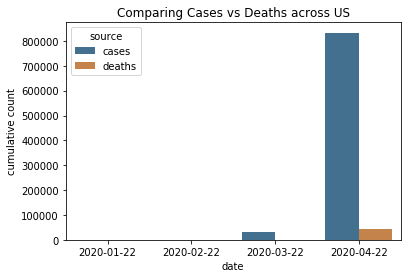

In [79]:
ax = sns.barplot(x = "date", y="value_numbers", data=test_data_melt.reset_index(), hue = "source", 
                 ci=None, saturation=.5)
plt.title('Comparing Cases vs Deaths across US')
plt.ylabel('cumulative count')

## Predicting cumulative deaths with number of covid-19 cases and healthcare capability data

### Using March # of deaths to train the model

In [82]:
data = pd.read_csv(r'data_clean_3_21.csv')
april_data = pd.read_csv(r'data_clean_4_21.csv')

In [120]:
# remove those without fips_code
data.dropna(subset = ["fips_code"], inplace=True)
data.dropna(subset = ["ICU.Bed.Occupancy.Rate"], inplace=True)
data.dropna(subset = ["population_20"], inplace=True)
#data.isnull().sum()
X = data.drop(['fips_code', 'date', 'county', 'State', 'Staffed.All.Beds', 'Staffed.ICU.Beds', 'Licensed.All.Beds',
       'All.Bed.Occupancy.Rate', 'ICU.Bed.Occupancy.Rate', 'Population', 'Population_2010',
       'Population..20..', 'Population..65..',
       'Staffed.All.Beds..Per.1000.People.',
       'Staffed.All.Beds..Per.1000.Adults..20...',
       'Staffed.All.Beds..Per.1000.Elderly..65...',
       'Staffed.ICU.Beds..Per.1000.People.',
       'Staffed.ICU.Beds..Per.1000.Adults..20...', 'Description',
       'Staffed.ICU.Beds..Per.1000.Elderly..65...',
       'Licensed.All.Beds..Per.1000.People.',
       'Licensed.All.Beds..Per.1000.Adults..20...', 'staffed_all_beds_.per_1000_people.',
       'staffed_all_beds_.per_1000_adults_20..',
       'staffed_all_beds_.per_1000_elderly_65..',
       'staffed_icu_beds_.per_1000_people.',
       'staffed_icu_beds_.per_1000_adults_20..',
       'staffed_icu_beds_.per_1000_elderly_65..',
       'licensed_all_beds_per_1000_people',
       'licensed_all_beds_.per_1000_adults_20..',
       'licensed_all_beds_.per_1000_elderly_65..',
       'Licensed.All.Beds..Per.1000.Elderly..65...', 'county_x', 'County_Name', 'Area_name'], axis = 1)
X['state'] = X.state.factorize()[0]
#X['Description'] = X.Description.factorize()[0]
X['peopleinpoverty2018'] = X.peopleinpoverty2018.factorize()[0]
X['medianhouseholdincome'] = X.medianhouseholdincome.factorize()[0]
Y_d = data['deaths']
X_new = X.drop(['deaths'], axis = 1)

### Feature selection

In [107]:
X.columns

Index(['state', 'cases', 'staffed_all_beds', 'staffed_icu_beds',
       'licensed_all_beds', 'all_bed_occupancy_rate', 'icu_bed_occupancy_rate',
       'population', 'population_20', 'population_65', 'RUCC_2013',
       'Rural.urban_Continuum_Code_2013', 'Urban_Influence_Code_2013',
       'peopleinpoverty2018', 'medianhouseholdincome'],
      dtype='object')

In [122]:
X_train, X_valid, y_train, y_valid = train_test_split(X_new, Y_d, test_size = 0.7, random_state = 1)
rf = RandomForestClassifier() 
rf.fit(X_train, y_train) 
rf.score(X_valid, y_valid)
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
cases,0.113785
licensed_all_beds,0.108304
population,0.096992
population_65,0.089410
population_20,0.082091
staffed_all_beds,0.075511
staffed_icu_beds,0.071556
all_bed_occupancy_rate,0.070759
icu_bed_occupancy_rate,0.070095
medianhouseholdincome,0.068613


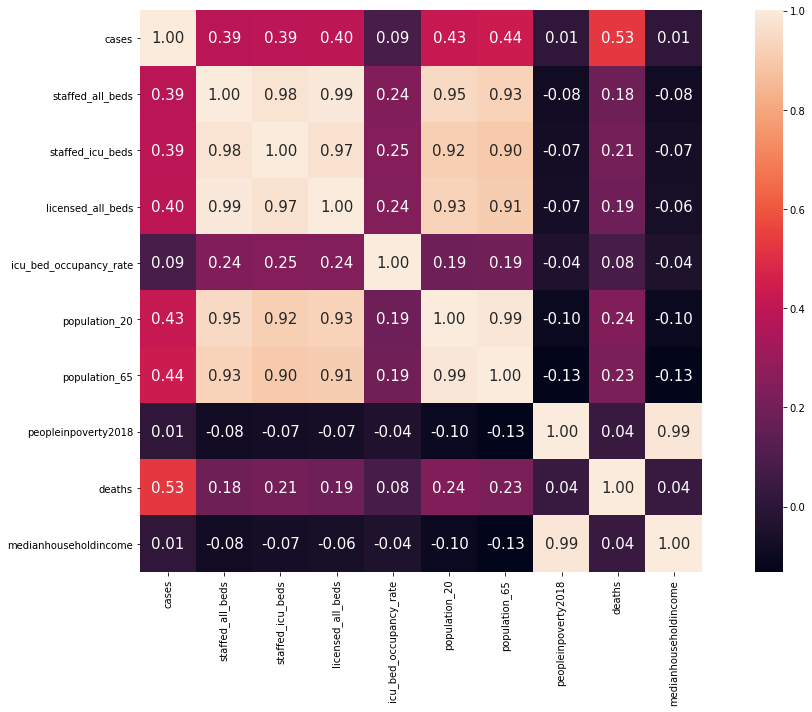

In [118]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
cols = ['cases', 'staffed_all_beds', 'staffed_icu_beds',
       'licensed_all_beds', 'icu_bed_occupancy_rate',
        'population_20', 'population_65', 'peopleinpoverty2018', 'deaths',
       'medianhouseholdincome']
X_std = stdsc.fit_transform(X[cols].iloc[:,range(0,10)].values)
cov_mat =np.cov(X_std.T)
plt.figure(figsize=(15,10))
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)
plt.tight_layout()
#plt.savefig('images/10_04.png', dpi=300)
plt.show()

### Selected variables: 
cases, staffed all beds, staffed icu beds, licensed all beds, population 20, population 65

## Regression Models

In [123]:
X_d = X[['population_20', 'population_65', 'licensed_all_beds', 'staffed_all_beds', 'cases', 'staffed_all_beds']]


X_train, X_test, y_train, y_test = train_test_split(X_d, Y_d, test_size=0.3)

In [124]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [151]:
#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
#fit model to training data
knn_gs.fit(X_train, y_train)
#save best model
knn_best = knn_gs.best_estimator_
#check best n_neigbors value
print(knn_gs.best_params_)
#create a new random forest classifier
rf = RandomForestClassifier()
#create a dictionary of all values we want to test for n_estimators
params_rf = {'n_estimators': [50, 100, 200]}
#use gridsearch to test all values for n_estimators
rf_gs = GridSearchCV(rf, params_rf, cv=5)
#fit model to training data
rf_gs.fit(X_train, y_train)
#save best model
rf_best = rf_gs.best_estimator_
#check best n_estimators value
print(rf_gs.best_params_)
#create a new logistic regression model
log_reg = LogisticRegression()
#fit the model to the training data
log_reg.fit(X_train, y_train)

/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'n_neighbors': 10}


/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'n_estimators': 100}


/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [152]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=5, 
                                 n_estimators=3, 
                                 learning_rate=1.0)
gbrt.fit(X_train, y_train)
gbrt.score(X_test, y_test)

-2.031783132036213

In [153]:
print('knn: {}'.format(knn_best.score(X_test, y_test)))
print('rf: {}'.format(rf_best.score(X_test, y_test)))
print('log_reg: {}'.format(log_reg.score(X_test, y_test)))
print('gbrt: {}'.format(gbrt.score(X_test, y_test)))

knn: 0.8711111111111111
rf: 0.8444444444444444
log_reg: 0.7511111111111111
gbrt: -2.031783132036213


In [154]:
print('MSE for gbrt: {}'.format(mean_squared_error(y_test, gbrt.predict(X_test))))
print('MSE for rf: {}'.format(mean_squared_error(y_test, rf_best.predict(X_test))))
print('MSE for log_reg: {}'.format(mean_squared_error(y_test, log_reg.predict(X_test))))

MSE for gbrt: 1.007659910708964
MSE for rf: 0.36
MSE for log_reg: 103.44


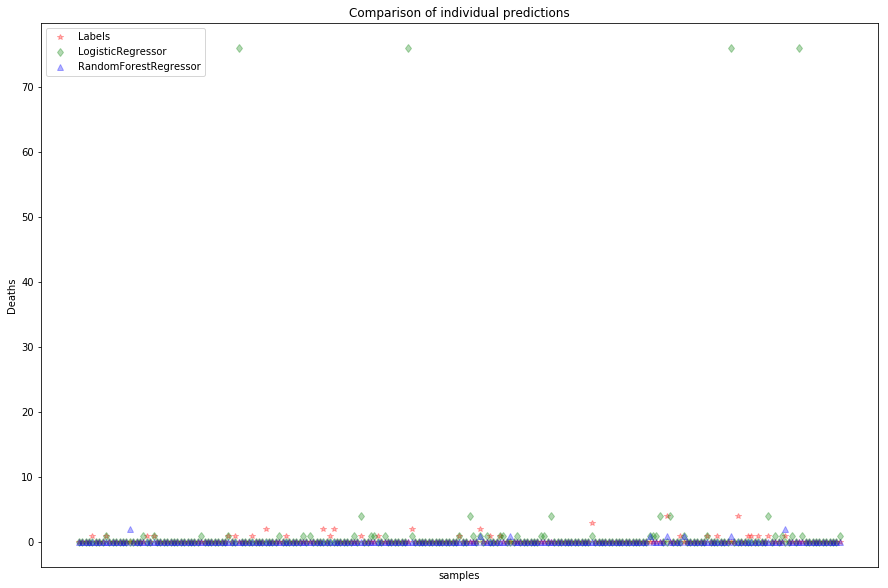

In [155]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(y_test.shape[0]), y_test, 'r*', label='Labels', alpha=0.3)
plt.plot(np.arange(y_test.shape[0]), log_reg.predict(X_test), 'gd', label='LogisticRegressor', alpha=0.3)
plt.plot(np.arange(y_test.shape[0]), rf_best.predict(X_test), 'b^', label='RandomForestRegressor', alpha=0.3)

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('Deaths')
plt.xlabel('samples')
plt.legend(loc="best")
plt.title('Comparison of individual predictions')
plt.show()

## Voting Classifier

In [158]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[('knn', knn_best), ('rf', rf_best), ('log_reg', log_reg)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

In [159]:
#fit model to training data
ensemble.fit(X_train, y_train)
#test our model on the test data
ensemble.score(X_test, y_test)

/opt/anaconda3/envs/Computational_methods/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8622222222222222

## Predicting April Deaths

In [170]:
# remove those without fips_code
april_data.dropna(subset = ["fips_code"], inplace=True)
april_data.dropna(subset = ["ICU.Bed.Occupancy.Rate"], inplace=True)
april_data.dropna(subset = ["population_20"], inplace=True)
#data.isnull().sum()
X = april_data.drop(['fips_code', 'date', 'county', 'State', 'Staffed.All.Beds', 'Staffed.ICU.Beds', 'Licensed.All.Beds',
       'All.Bed.Occupancy.Rate', 'ICU.Bed.Occupancy.Rate', 'Population', 'Population_2010',
       'Population..20..', 'Population..65..',
       'Staffed.All.Beds..Per.1000.People.',
       'Staffed.All.Beds..Per.1000.Adults..20...',
       'Staffed.All.Beds..Per.1000.Elderly..65...',
       'Staffed.ICU.Beds..Per.1000.People.',
       'Staffed.ICU.Beds..Per.1000.Adults..20...', 'Description',
       'Staffed.ICU.Beds..Per.1000.Elderly..65...',
       'Licensed.All.Beds..Per.1000.People.',
       'Licensed.All.Beds..Per.1000.Adults..20...', 'staffed_all_beds_.per_1000_people.',
       'staffed_all_beds_.per_1000_adults_20..',
       'staffed_all_beds_.per_1000_elderly_65..',
       'staffed_icu_beds_.per_1000_people.',
       'staffed_icu_beds_.per_1000_adults_20..',
       'staffed_icu_beds_.per_1000_elderly_65..',
       'licensed_all_beds_per_1000_people',
       'licensed_all_beds_.per_1000_adults_20..',
       'licensed_all_beds_.per_1000_elderly_65..',
       'Licensed.All.Beds..Per.1000.Elderly..65...', 'county_x', 'County_Name', 'Area_name'], axis = 1)
X['state'] = X.state.factorize()[0]
#X['Description'] = X.Description.factorize()[0]
X['peopleinpoverty2018'] = X.peopleinpoverty2018.factorize()[0]
X['medianhouseholdincome'] = X.medianhouseholdincome.factorize()[0]
Y_d = april_data['deaths']
X_new = X.drop(['deaths'], axis = 1)

X_april = X[['population_20', 'population_65', 'licensed_all_beds', 'staffed_all_beds', 'cases', 'staffed_all_beds']]

In [171]:
print('MSE for rf: {}'.format(mean_squared_error(Y_d, rf_best.predict(X_april))))
print('MSE for log_reg: {}'.format(mean_squared_error(Y_d, log_reg.predict(X_april))))

MSE for rf: 9141.780791788857
MSE for log_reg: 9393.409824046921


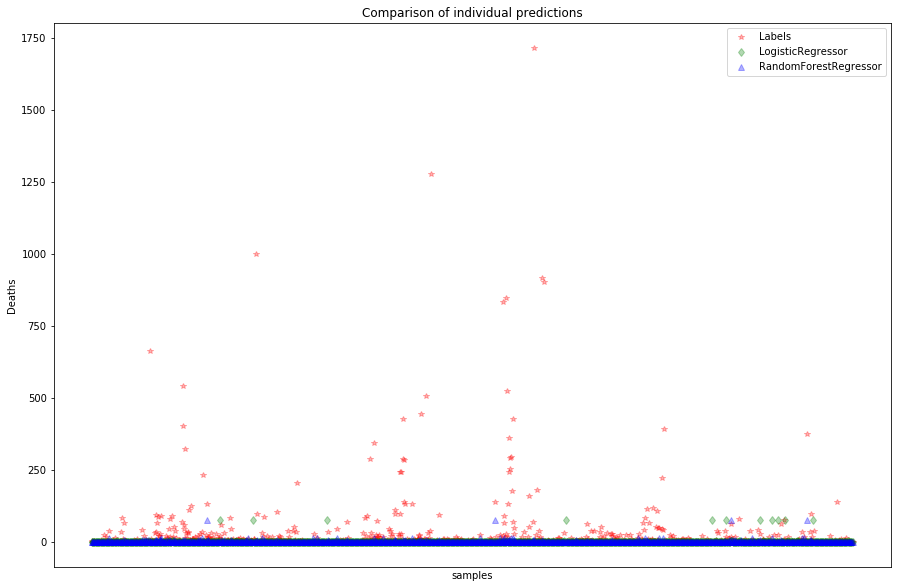

In [172]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(Y_d.shape[0]), Y_d, 'r*', label='Labels', alpha=0.3)
plt.plot(np.arange(Y_d.shape[0]), log_reg.predict(X_april), 'gd', label='LogisticRegressor', alpha=0.3)
plt.plot(np.arange(Y_d.shape[0]), rf_best.predict(X_april), 'b^', label='RandomForestRegressor', alpha=0.3)

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('Deaths')
plt.xlabel('samples')
plt.legend(loc="best")
plt.title('Comparison of individual predictions')
plt.show()